In [1]:
import sys
sys.path.append('../../lib/')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from jax.example_libraries.optimizers import adam, unpack_optimizer_state, pack_optimizer_state
import pickle

jax.config.update('jax_platform_name', 'cpu')
from hetero_simulation.econ_models.housing_renter import neural_network, renter_policy, econ_config, ml_config, draw_states, loss, params0
from hetero_simulation.archive.agent import log_utility
from hetero_simulation.ml.utils import *
utility = lambda c, h, n: log_utility()(c) + log_utility()(h) + log_utility()(1 - n)

In [2]:
opt_init, opt_update, get_params = adam(step_size=0.001)
saved_params = pickle.load(open(f'../models/renter_model_latest.pkl', 'rb'))
opt_state = pack_optimizer_state(saved_params)
params = get_params(opt_state)

In [3]:
m = jnp.linspace(0, 2, 10001)
a = jnp.linspace(0, 1, 1001)
b = jnp.linspace(0, 1, 1001)
z = jnp.linspace(0.5, 1.5, 101)
i = jnp.linspace(0.01, 0.1, 101)
t = jnp.linspace(0, econ_config['T'], 101)

In [4]:
z0 = jnp.ones(1)
i0 = econ_config['ibar'] * jnp.ones(1)

In [5]:
a0 = 0. * jnp.ones(1)
b0 = 0. * jnp.ones(1)
o0 = 0. * jnp.ones(1)
t0 = 20. * jnp.ones(1)
v0, c0, h0, n0, m1, a1, b1, o1, bc, l0 = jax.vmap(lambda m0: neural_network(params, z0, i0, m0, a0, b0, o0, t0))(m)
v1f = lambda params, z1, i1, m1, a1, b1, o1, t1: neural_network(params, z1, i1, m1, a1, b1, o1, t1)[0]
v1 = jax.vmap(lambda m1, a1, b1, o1: v1f(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)

v0f = lambda params, z0, i0, m0, a0, b0, o0, t0: neural_network(params, z0, i0, m0, a0, b0, o0, t0)[0][0]
v0_grad = jax.vmap(lambda m0: jax.grad(v0f, (3, 4, 5))(params, z0, i0, m0, a0, b0, o0, t0))(m)
v0 = jax.vmap(lambda m0: v0f(params, z0, i0, m0, a0, b0, o0, t0))(m)
v0m = v0_grad[0]
v0a = v0_grad[1]
v0b = v0_grad[2]

v1f = lambda params, z1, i1, m1, a1, b1, o1, t1: neural_network(params, z1, i1, m1, a1, b1, o1, t1)[0][0]
v1 = jax.vmap(lambda m1, a1, b1, o1: v1f(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)
v1_grad = jax.vmap(lambda m1, a1, b1, o1: jax.grad(v1f, (3, 4, 5))(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)
v1m = v1_grad[0]
v1a = v1_grad[1]
v1b = v1_grad[2]

u = jax.vmap(utility)(c0, h0, n0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), h0.reshape(-1, 1), n0.reshape(-1, 1),
                                   m1.reshape(-1, 1), a1.reshape(-1, 1), b1.reshape(-1, 1),
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), v1.reshape(-1, 1),
                                   l0.reshape(-1, 1), m.reshape(-1, 1), u.reshape(-1, 1),
                                   v0m.reshape(-1, 1), v0a.reshape(-1, 1), v0b.reshape(-1, 1),
                                   v1m.reshape(-1, 1), v1a.reshape(-1, 1), v1b.reshape(-1, 1)),
                                   axis=1))
df.columns = ['rc', 'rh', 'rn', 'rm', 'ra', 'rb', 'rbc', 'rv0', 'rv1', 'rl0', 'm0', 'ru', 'rv0m', 'rv0a', 'rv0b', 'rv1m', 'rv1a', 'rv1b']
df.set_index('m0', inplace=True)

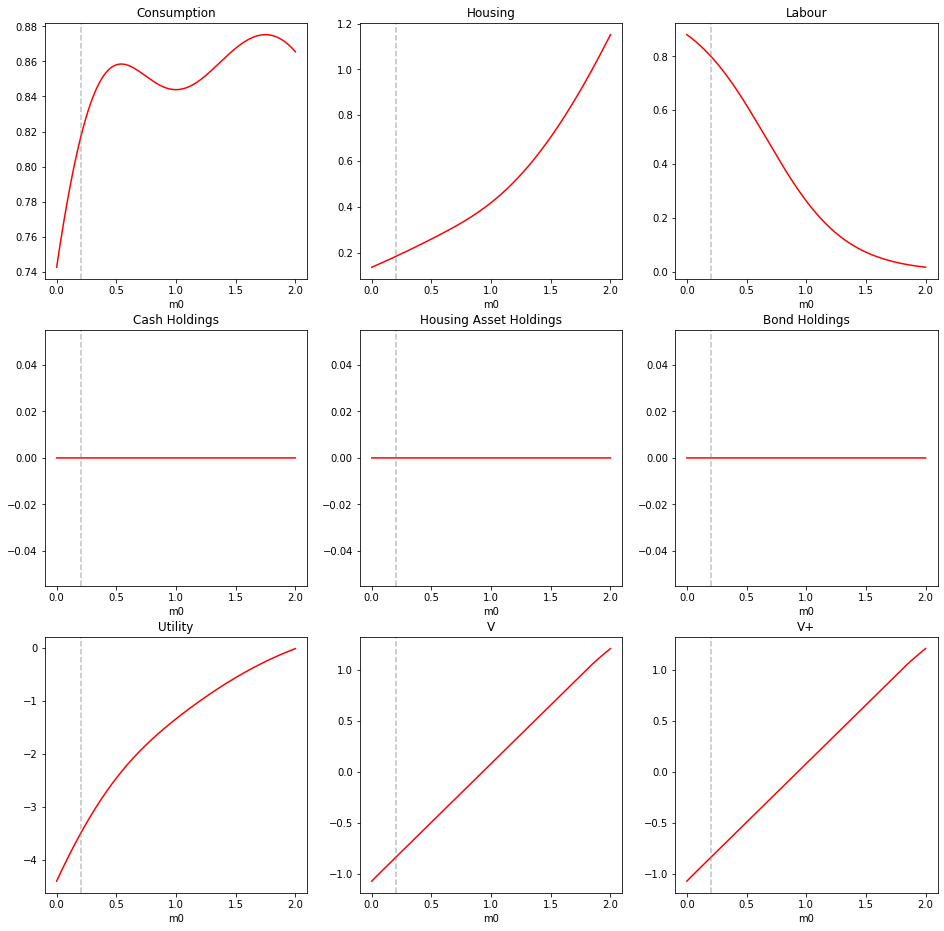

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
_ = df['rc'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='red')
_ = df['rh'].plot(kind='line', ax=axes.flatten()[1], title='Housing', c='red')
_ = df['rn'].plot(kind='line', ax=axes.flatten()[2], title='Labour', c='red')
_ = df['rm'].plot(kind='line', ax=axes.flatten()[3], title='Cash Holdings', c='red')
_ = df['ra'].plot(kind='line', ax=axes.flatten()[4], title='Housing Asset Holdings', c='red')
_ = df['rb'].plot(kind='line', ax=axes.flatten()[5], title='Bond Holdings', c='red')
_ = df['ru'].plot(kind='line', ax=axes.flatten()[6], title='Utility', c='red')
_ = df['rv0'].plot(kind='line', ax=axes.flatten()[7], title='V', c='red')
_ = df['rv1'].plot(kind='line', ax=axes.flatten()[8], title='V+', c='red')

for ax in axes.flatten():
    ax.axvline(x=(econ_config['phi']*econ_config['pa']), color='grey', linestyle='--', alpha=0.5)

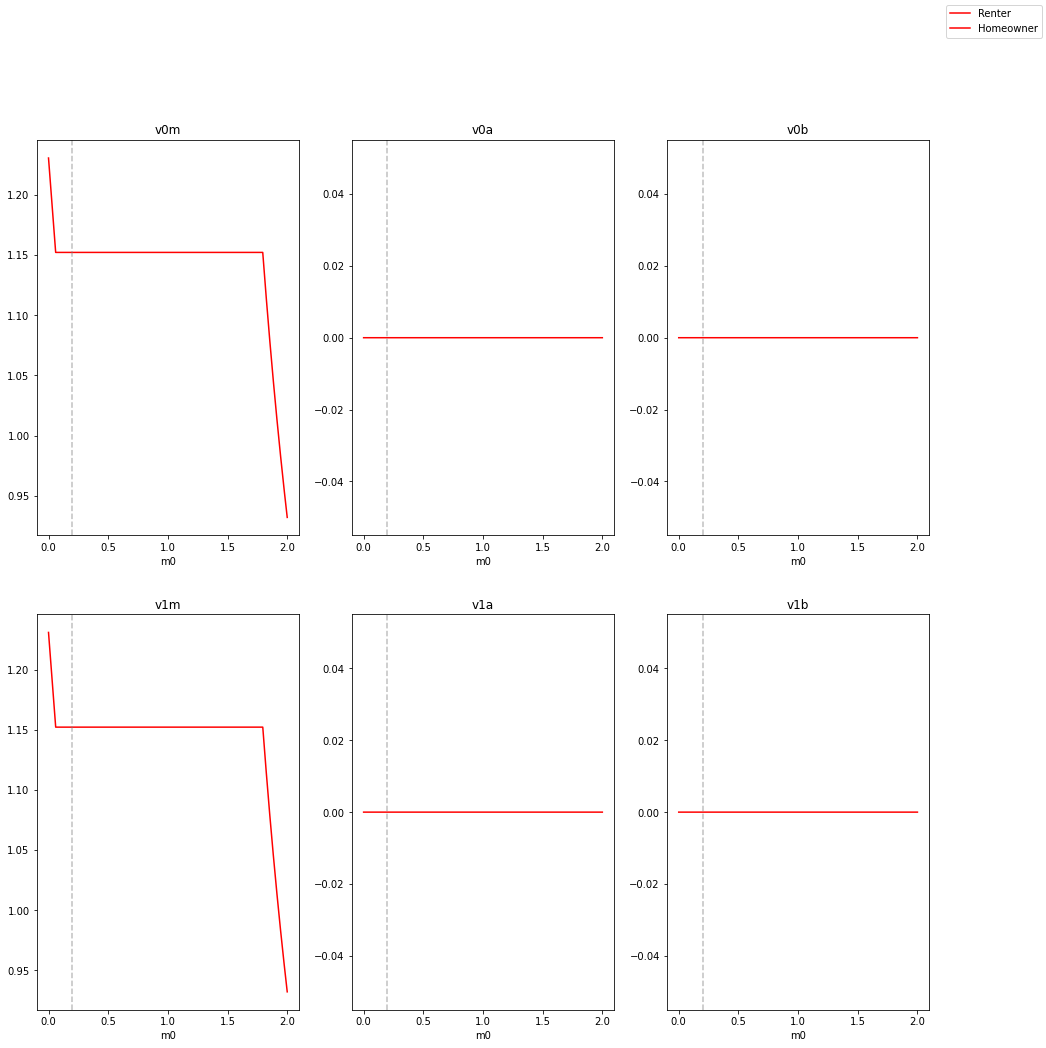

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(16,16))
_ = df['rv0m'].plot(kind='line', ax=axes.flatten()[0], title='v0m', c='red')
_ = df['rv0a'].plot(kind='line', ax=axes.flatten()[1], title='v0a', c='red')
_ = df['rv0b'].plot(kind='line', ax=axes.flatten()[2], title='v0b', c='red')
_ = df['rv1m'].plot(kind='line', ax=axes.flatten()[3], title='v1m', c='red')
_ = df['rv1a'].plot(kind='line', ax=axes.flatten()[4], title='v1a', c='red')
_ = df['rv1b'].plot(kind='line', ax=axes.flatten()[5], title='v1b', c='red')

_ = fig.legend(['Renter', 'Homeowner'])
for ax in axes.flatten():
    ax.axvline(x=(econ_config['phi']*econ_config['pa']), color='grey', linestyle='--', alpha=0.5)

<AxesSubplot:xlabel='m0'>

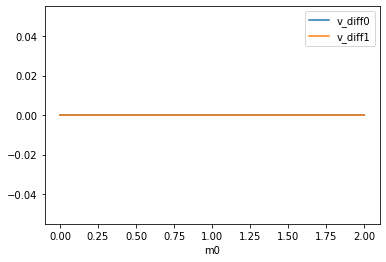

In [8]:
@jax.jit
def v_diff(params, z0, i0, m0, t0):
    ov0, _, _, _, om1, oa1, ob1, _, _, _ = neural_network(params, z0, i0, m0, 0., 0., 1., t0)
    rv0, _, _, _, rm1, ra1, rb1, _, _, _ = neural_network(params, z0, i0, m0, 0., 0., 0., t0)
    
    ov1 = neural_network(params, z0, i0, om1, oa1, ob1, 1., t0 + 1)[0]
    rv1 = neural_network(params, z0, i0, rm1, ra1, rb1, 0., t0 + 1)[0]
    
    return (ov0 - rv0, ov1 - rv1)

v_diff0, v_diff1 = jax.vmap(v_diff, in_axes=(None, None, None, 0, None))(params, z0, i0, m, t0)
v_diff_df = pd.DataFrame(jnp.concatenate((m.reshape(-1, 1), v_diff0.reshape(-1, 1), v_diff1.reshape(-1, 1)), axis=1))
v_diff_df.columns = ['m0', 'v_diff0', 'v_diff1']
v_diff_df.set_index('m0').plot()

<AxesSubplot:xlabel='m0'>

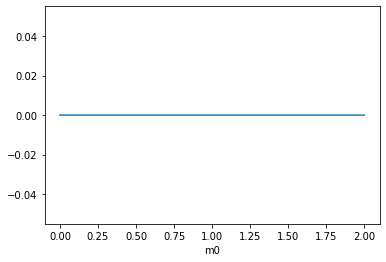

In [9]:
df['rsavings'] = df['rm'] + df['ra']
df['rsavings'] = df['rsavings'] + df['rb']
df['rsavings'].plot()

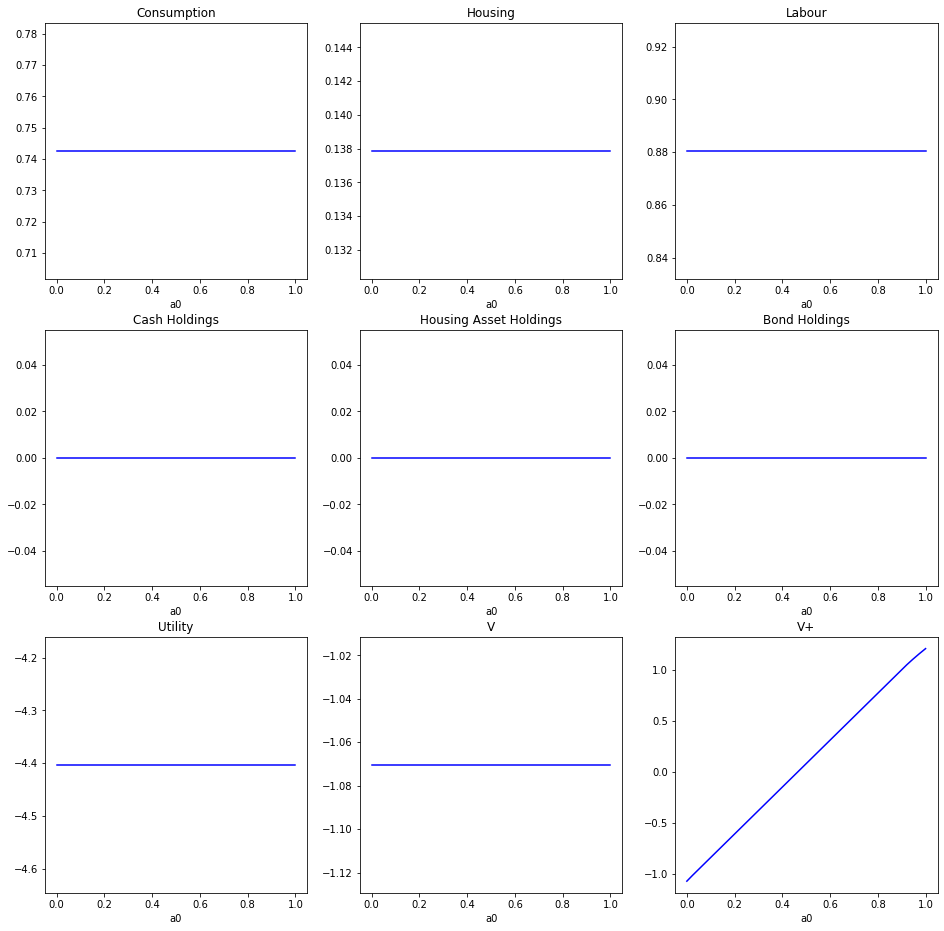

In [10]:
m = jnp.linspace(0, 2, 1001)
     
m0 = jnp.zeros(1)
o0 = jnp.ones(1)
v0, c0, h0, n0, m1, a1, b1, o1, bc, l0 = jax.vmap(lambda a0, b0: neural_network(params, z0, i0, m0, a0, b0, o0, t0))(a, b)
v1 = jax.vmap(lambda m1, a1, b1, o1: v1f(params, z0, i0, m1, a1, b1, o1, t0 + 1))(m, a1, b1, o1)
u = jax.vmap(utility)(c0, h0, n0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), h0.reshape(-1, 1), n0.reshape(-1, 1),
                                   m1.reshape(-1, 1), a1.reshape(-1, 1), b1.reshape(-1, 1),
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), v1.reshape(-1, 1),
                                   l0.reshape(-1, 1), a.reshape(-1, 1), u.reshape(-1, 1)),
                                   axis=1))
df.columns = ['c', 'h', 'n', 'm', 'a', 'b', 'bc', 'v0', 'v1', 'l0', 'a0', 'u']
df.set_index('a0', inplace=True)

fig, axes = plt.subplots(3, 3, figsize=(16,16))
_ = df['c'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='blue')
_ = df['h'].plot(kind='line', ax=axes.flatten()[1], title='Housing', c='blue')
_ = df['n'].plot(kind='line', ax=axes.flatten()[2], title='Labour', c='blue')
_ = df['m'].plot(kind='line', ax=axes.flatten()[3], title='Cash Holdings', c='blue')
_ = df['a'].plot(kind='line', ax=axes.flatten()[4], title='Housing Asset Holdings', c='blue')
_ = df['b'].plot(kind='line', ax=axes.flatten()[5], title='Bond Holdings', c='blue')
_ = df['u'].plot(kind='line', ax=axes.flatten()[6], title='Utility', c='blue')
_ = df['v0'].plot(kind='line', ax=axes.flatten()[7], title='V', c='blue')
_ = df['v1'].plot(kind='line', ax=axes.flatten()[8], title='V+', c='blue')

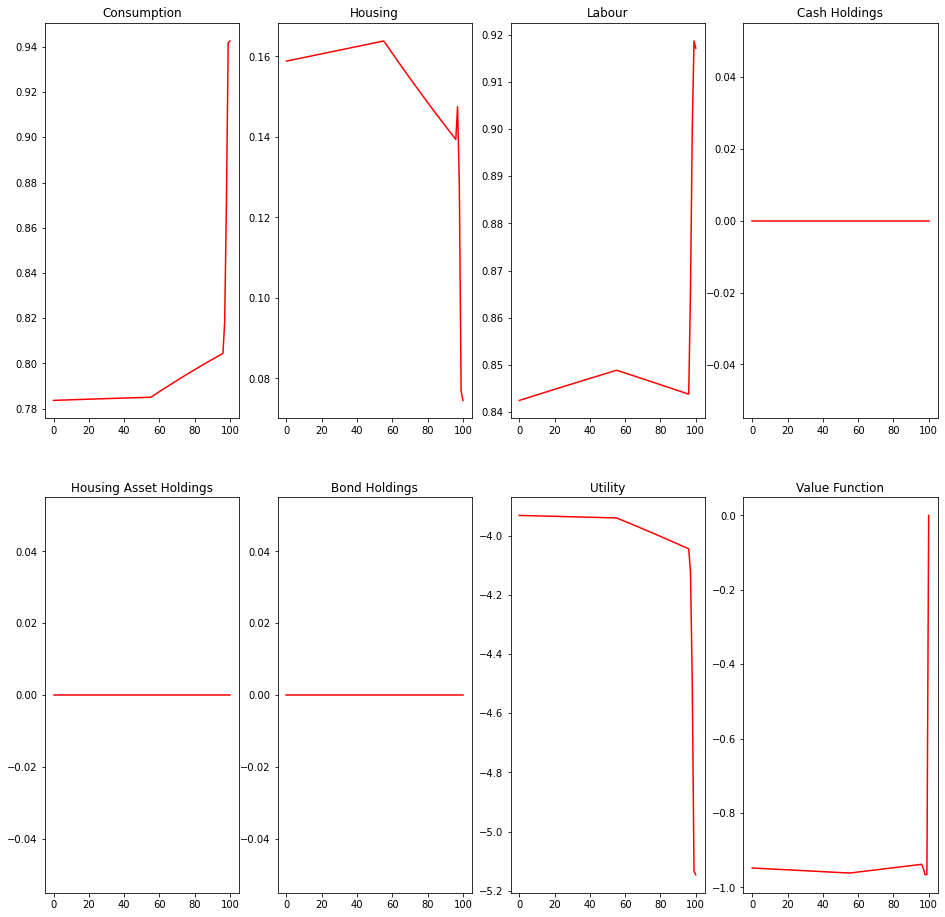

In [11]:
a0 = 0. * jnp.ones(1)
b0 = 0. * jnp.ones(1)
m0 = 0.1 * jnp.ones(1)
o0 = 0. * jnp.ones(1)
v0, c0, h0, n0, m1, a1, b1, o1, bc, l0 = jax.vmap(lambda t0: neural_network(params, z0, i0, m0, a0, b0, o0, t0))(t)
u = jax.vmap(utility)(c0, h0, n0)
df = pd.DataFrame(jnp.concatenate((c0.reshape(-1, 1), h0.reshape(-1, 1), n0.reshape(-1, 1),
                                   m1.reshape(-1, 1), a1.reshape(-1, 1), b1.reshape(-1, 1),
                                   bc.reshape(-1, 1), v0.reshape(-1, 1), u.reshape(-1, 1)),
                                   axis=1))
df.columns = ['c', 'h', 'n', 'm', 'a', 'b', 'bc', 'v', 'u']

fig, axes = plt.subplots(2, 4, figsize=(16,16))
_ = df['c'].plot(kind='line', ax=axes.flatten()[0], title='Consumption', c='red')
_ = df['h'].plot(kind='line', ax=axes.flatten()[1], title='Housing', c='red')
_ = df['n'].plot(kind='line', ax=axes.flatten()[2], title='Labour', c='red')
_ = df['m'].plot(kind='line', ax=axes.flatten()[3], title='Cash Holdings', c='red')
_ = df['a'].plot(kind='line', ax=axes.flatten()[4], title='Housing Asset Holdings', c='red')
_ = df['b'].plot(kind='line', ax=axes.flatten()[5], title='Bond Holdings', c='red')
_ = df['u'].plot(kind='line', ax=axes.flatten()[6], title='Utility', c='red')
_ = df['v'].plot(kind='line', ax=axes.flatten()[7], title='Value Function', c='red')

In [12]:
df

,c,h,n,m,a,b,bc,v,u
0,0.783609,0.158838,0.842447,0.0,0.0,0.0,-0.158838,-0.947948,-3.931710
1,0.783637,0.158928,0.842565,0.0,0.0,0.0,-0.158928,-0.948194,-3.931858
2,0.783665,0.159017,0.842683,0.0,0.0,0.0,-0.159017,-0.948440,-3.932006
3,0.783693,0.159107,0.842801,0.0,0.0,0.0,-0.159107,-0.948687,-3.932154
4,0.783721,0.159197,0.842919,0.0,0.0,0.0,-0.159197,-0.948932,-3.932303
...,...,...,...,...,...,...,...,...,...
96,0.804396,0.139376,0.843773,0.0,0.0,0.0,-0.139376,-0.938036,-4.044684
97,0.818120,0.147524,0.865644,0.0,0.0,0.0,-0.147524,-0.949916,-4.121774
98,0.871796,0.128023,0.899819,0.0,0.0,0.0,-0.128023,-0.966319,-4.493520
99,0.941793,0.076878,0.918672,0.0,0.0,0.0,-0.076878,-0.965263,-5.134763


In [13]:
m0 = 0.200
a0 = 0.
b0 = 0.
t0 = 20.

_, _, _, _, rm1, ra1, rb1, _, _, _ = neural_network(params, z0, i0, m0, a0, b0, 0., t0)
_, c0, h0, n0, om1, oa1, ob1, _, _, _ = neural_network(params, z0, i0, m0, a0, b0, 1., t0)
v_diff = v1f(params, z0, i0, om1, oa1, ob1, 1., t0 + 1) - v1f(params, z0, i0, rm1, ra1, rb1, 0., t0 + 1)
v_diff

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [ ]:
t = jnp.concatenate((jnp.linspace(0, 80, 60), jnp.linspace(80, 100, 20), 100 * jnp.ones(21)))
t

In [ ]:
jnp.arange(100)

In [ ]:
jax.grad(lambda c0, h0, n0: utility(c0, h0, n0)[0], (0, 1, 2))(c0, h0, n0)

In [ ]:
jax.grad(v1f, (3, 4, 5))(params, z0, i0, om1, oa1, ob1, 1., t0 + 1)

In [ ]:
m0 = 0.
a0 = 0.2
b0 = 0.2
o0 = 1.
t0 = 100.
z0 = 1.
i0 = econ_config['ibar']

In [ ]:
neural_network(params, z0, i0, m0, a0, b0, o0, 99.)

In [ ]:
loss_bellman, loss_focc, loss_foch, loss_focn, loss_focm1, loss_foca1, loss_focb1, loss_focm0, loss_foca0, loss_focb0, loss_focem0, loss_focea0, loss_foceb0 = loss(params, m0, a0, b0, o0, t0, z0, i0, jax.random.PRNGKey(1))
print(f'loss_bellman: {loss_bellman**2:2.2f}')
print(f'loss_focc: {loss_focc**2:2.2f}')
print(f'loss_foch: {loss_foch**2:2.2f}')
print(f'loss_focn: {loss_focn**2:2.2f}')
print(f'loss_focm1: {loss_focm1**2:2.2f}')
print(f'loss_foca1: {loss_foca1**2:2.2f}')
print(f'loss_focb1: {loss_focb1**2:2.2f}')
print(f'loss_focm0: {loss_focm0**2:2.2f}')
print(f'loss_foca0: {loss_foca0**2:2.2f}')
print(f'loss_focb0: {loss_focb0**2:2.2f}')
print(f'loss_focem0: {loss_focb0**2:2.2f}')
print(f'loss_focea0: {loss_focb0**2:2.2f}')
print(f'loss_foceb0: {loss_focb0**2:2.2f}')

In [ ]:
scale = 0.4
init_keys = jax.random.split(jax.random.PRNGKey(np.random.randint(1, int(1e8))), 11)
w00o = scale * jax.random.normal(init_keys[1], shape=(6, ml_config['nn_shapes'][0]))
w00r = scale * jax.random.normal(init_keys[1], shape=(5, ml_config['nn_shapes'][0]))
w01 = scale * jax.random.normal(init_keys[2], shape=(ml_config['nn_shapes'][0], ml_config['nn_shapes'][1]))
w02 = scale * jax.random.normal(init_keys[3], shape=(ml_config['nn_shapes'][1], ml_config['nn_shapes'][2]))
w03 = scale * jax.random.normal(init_keys[3], shape=(ml_config['nn_shapes'][2], ml_config['nn_shapes'][3]))
w0f = scale * jax.random.normal(init_keys[4], shape=(ml_config['nn_shapes'][2], 1))
b00 = scale * jax.random.normal(init_keys[5], shape=(1, ml_config['nn_shapes'][0]))
b01 = scale * jax.random.normal(init_keys[6], shape=(1, ml_config['nn_shapes'][1]))
b02 = scale * jax.random.normal(init_keys[7], shape=(1, ml_config['nn_shapes'][2]))
b03 = scale * jax.random.normal(init_keys[7], shape=(1, ml_config['nn_shapes'][3]))
b0f = scale * jax.random.normal(init_keys[8], shape=(1, 1))
params0 = {
    'owner': {
        'w0': w00o, 'w1': w01, 'w2': w02, 'w3': w03, 'cwf': w0f, 'nwf': w0f, 'swf': w0f, 'dwf': w0f, 'bwf': w0f, 'iwf': w0f, 'vwf': w0f,
        'b0': b00, 'b1': b01, 'b2': b02, 'b3': b03, 'cbf': b0f, 'nbf': b0f, 'sbf': b0f, 'dbf': b0f, 'bbf': b0f, 'ibf': b0f, 'vbf': b0f
    },
    'renter': {
        'w0': w00r, 'w1': w01, 'w2': w02, 'w3': w03, 'cwf': w0f, 'nwf': w0f, 'swf': w0f, 'dwf': w0f, 'bwf': w0f, 'iwf': w0f, 'vwf': w0f,
        'b0': b00, 'b1': b01, 'b2': b02, 'b3': b03, 'cbf': b0f, 'nbf': b0f, 'sbf': b0f, 'dbf': b0f, 'bbf': b0f, 'ibf': b0f, 'vbf': b0f
    }
}

In [ ]:
z1 = 1
i1 = econ_config['ibar']
m1 = 0.1
a1 = 0.5
b1 = 0.5
o1 = 1.
t0 = 49.

v1f = lambda params, z1, i1, m1, a1, b1, o1, t1: neural_network(params, z1, i1, m1, a1, b1, o1, t1)[0]
v1 = v1f(params, z1, i1, m1, a1, b1, o1, t0 + 1)
v1_grad = jax.grad(v1f, (3, 4, 5))(params, z1, i1, m1, a1, b1, o1, t0 + 1)

In [ ]:
v1f(params, z1, i1, m1, a1, b1, 1., t0 + 1) - v1f(params, z1, i1, m1, a1, b1, 0., t0 + 1)

In [ ]:
params['owner']['vwf']

In [ ]:
@jax.jit
def custom_value_fn(x):
    return ((jnp.int32(x > 1) * (jnp.log(jnp.abs(x)) + 1)) +
           (jnp.int32(x < -1) * (-1 * (1/2)*jnp.power(x, 2) - (1/2))) +
           (jnp.int32(x <= 1) * jnp.int32(x >= -1) * x))

r = 1e10
x = jnp.linspace(-r, r, 1000)
y = custom_value_fn(x)
jnp.any(jnp.isnan(y))

In [ ]:
jax.grad(custom_value_fn)(1.)